# Optimization of a coarse KPP model

In this notebook we demonstrate the optimization of a coarse KPP model.

1. Free convection
2. Wind-driven shear mixing with neutral buoyancy forcing
3. Wind-driven shear mixing with destabilizing buoyancy forcing
4. Wind-driven shear mixing with stabilizing buoyancy forcing

In [1]:
using Pkg; Pkg.activate("..")

using OceanTurb, ColumnModelOptimizationProject, PyPlot, Printf, Dao, ColumnModelOptimizationProject.KPPOptimization

datadir = joinpath("..", "data", "idealized")
cases = ["free_convection", "shear_neutral", "shear_unstable", "shear_stable"]
dirs = Dict((c, joinpath(datadir, c)) for c in cases)

examples = Dict(
    "free_convection" => "wind_stress_N256_tau0_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_neutral"   => "wind_stress_N256_tau0.1_Q0_dTdz0.001_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_unstable"  => "wind_stress_N256_tau0.1_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_stable"    => "wind_stress_N256_tau0.04_Q10_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2" )

examplepaths = Dict((c, joinpath(dirs[c], examples[c])) for c in cases)

Dict{String,String} with 4 entries:
  "shear_unstable"  => "../data/idealized/shear_unstable/wind_stress_N256_tau0.…
  "shear_stable"    => "../data/idealized/shear_stable/wind_stress_N256_tau0.04…
  "free_convection" => "../data/idealized/free_convection/wind_stress_N256_tau0…
  "shear_neutral"   => "../data/idealized/shear_neutral/wind_stress_N256_tau0.1…

# The model and the data

First we instantiate our column data and our column model.

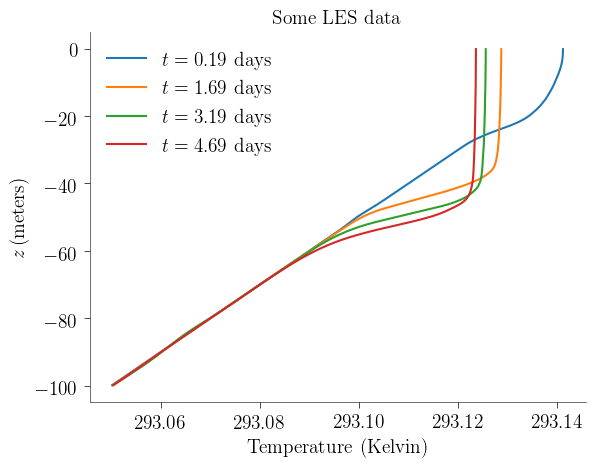

In [2]:
column_data = ColumnData(examplepaths["shear_neutral"]);
column_model = KPPOptimization.ColumnModel(column_data, 10*minute, N=10)

[ plot(column_data.T[i], label=@sprintf("\$ t = %0.2f \$ days", column_data.t[i]/day)) for i in (2, 10, 18, 26) ]
xlabel("Temperature (Kelvin)")
ylabel(L"z \, \mathrm{(meters)}")
title("Some LES data")
legend()
removespines("top", "right")

# The 'Negative Log Likelihood' function

Next we define a simple function to compute the negative log likelihood.

In [3]:
@show column_data.i_initial column_data.i_compare

function compute_nll(params, column_model, column_data)
    
    # Initialize the model
    kpp_parameters = KPP.Parameters(; dictify(params)...)
    column_model.model.parameters = kpp_parameters
    
    set!(column_model, column_data, column_data.i_initial)
    column_model.model.clock.time = column_data.t[column_data.i_initial]
    column_model.model.clock.iter = 0
    
    err = 0.0
    for i in column_data.i_compare
        run_until!(column_model.model, column_model.Δt, column_data.t[i])
        err += relative_error(column_model.model.solution.T, column_data.T[i]) / length(column_data.i_compare)
    end
    
    return err
end

nll = NegativeLogLikelihood(column_model, column_data, compute_nll, 1);

column_data.i_initial = 2
column_data.i_compare = (10, 18, 26)


# Compute the Markov Chain

In [4]:
default_params = DefaultFreeParameters(ShearNeutralParameters)
sampler = MetropolisSampler(NormalPerturbation([0.05*p for p in default_params]))
first_link = MarkovLink(nll, default_params)

dictify(default_params)

chain = MarkovChain(1000, first_link, nll, sampler)

similar(default_params) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
typeof(similar(default_params)) = ShearNeutralParameters{Float64}


ShearNeutralParameters{Float64}